In [1]:
import h5py
import imp
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub

import src.models.bilm
import src.models.bilm.data
# imp.reload(src.models.bilm.data)
# imp.reload(src.models.bilm)

from src import DATA_DIR
from src.models.bilm import dump_bilm_embeddings
from src.models.bilm.data import Vocabulary, UnicodeCharsVocabulary


In [2]:
vocab_file = os.path.join(DATA_DIR, 'elmo', 'vocab_elmo.txt')
elmo_vocab = Vocabulary(vocab_file)

In [3]:
def print_sentences(x1, x2, batch_size):
    for id_sample in range(batch_size):
        print("Premise:", elmo_vocab.decode(np.trim_zeros(x1[id_sample])-1))
        print("Hypo:", elmo_vocab.decode(np.trim_zeros(x2[id_sample])-1))

In [4]:
# Output of models/elmo_test.py
elmo_our_input = np.load(os.path.join(DATA_DIR, '/elmo/elmo_our_inp.npy')
elmo_our_output = np.load(os.path.join(DATA_DIR, '/elmo/elmo_our_out.npy')

In [5]:
print_sentences(elmo_our_input[0], elmo_our_input[1], elmo_our_input.shape[1])

Premise: <S> A restaurant worker is cleaning a seat . </S>
Hypo: <S> A restaurant worker is performing work duties . </S>
Premise: <S> Women in bikinis play beach volleyball by the waterside . </S>
Hypo: <S> Women are playing volleyball at a beach . </S>


In [6]:
print(elmo_our_output.shape)
print(elmo_our_input.shape)

(2, 2, 3, 90, 1024)
(2, 2, 90)


In [7]:
tokenized_premises = []
tokenized_hypothesis = []
for id_sample in range(elmo_our_input.shape[1]):
    tokenized_premises.append(elmo_vocab.decode(np.trim_zeros(elmo_our_input[0][id_sample])-1).split()[1:-1])
    tokenized_hypothesis.append(elmo_vocab.decode(np.trim_zeros(elmo_our_input[1][id_sample])-1).split()[1:-1])

print("PREM")
print(tokenized_premises)

print("HYPO")
print(tokenized_hypothesis)

length_premises = [len(sent) for sent in tokenized_premises]
length_hypothesis = [len(sent) for sent in tokenized_hypothesis]

print("Length premises:", length_premises)
print("Length hypothesis:", length_hypothesis)

PREM
[['A', 'restaurant', 'worker', 'is', 'cleaning', 'a', 'seat', '.'], ['Women', 'in', 'bikinis', 'play', 'beach', 'volleyball', 'by', 'the', 'waterside', '.']]
HYPO
[['A', 'restaurant', 'worker', 'is', 'performing', 'work', 'duties', '.'], ['Women', 'are', 'playing', 'volleyball', 'at', 'a', 'beach', '.']]
Length premises: [8, 10]
Length hypothesis: [8, 8]


In [8]:
# sess = tf.InteractiveSession()
# elmo = hub.Module("/home/z1079621/storage/embeddings/elmohub/", trainable=False)
# sess.run(tf.global_variables_initializer())
# sess.run(tf.tables_initializer())

In [9]:
# def send_to_hub(tokens_without_padding):
#     maxlen = 0
#     for sentence in tokens_without_padding:
#         maxlen = max(maxlen, len(sentence))
        
#     tokens = []
#     lengths = []
    
#     for sentence in tokens_without_padding:
#         sentence = sentence[:maxlen]
#         lengths.append(len(sentence))
#         sentence = sentence + ["" for _ in range(max(0, maxlen - len(sentence)))]
#         tokens.append(sentence)

#     return elmo(
#         inputs={
#             "tokens": tokens,
#             "sequence_len": lengths
#         },
#         signature="tokens",
#         as_dict=True
#     )['word_emb'].eval()

In [10]:
# hub_embeddings_premises = send_to_hub(tokenized_premises)
# hub_embeddings_hypothesis = send_to_hub(tokenized_hypothesis)

In [12]:
# Get embeddings from tf-bilm model

dataset_file = os.path.join(DATA_DIR, 'elmo', 'dataset_file.txt')
with open(dataset_file, 'w') as fout:
    for sentence in tokenized_premises:
        fout.write(' '.join(sentence) + '\n')
    for sentence in tokenized_hypothesis:
        fout.write(' '.join(sentence) + '\n')

datadir = os.path.join(DATA_DIR, 'elmo')
options_file = os.path.join(datadir, 'options.json')
weight_file = os.path.join(datadir, 'lm_weights.hdf5')

# Dump the embeddings to a file. Run this once for your dataset.
embedding_file = os.path.join(datadir, 'elmo_bilm_sample_embeddings.hdf5')
dump_bilm_embeddings(
    vocab_file, dataset_file, options_file, weight_file, embedding_file
)

USING SKIP CONNECTIONS


In [13]:
hub_embeddings_premises = []    
hub_embeddings_hypothesis = []

with h5py.File(embedding_file, 'r') as fin:
    for i in range(2):
        cur = fin['%d' % i][...]
        hub_embeddings_premises.append(cur)                              
    for i in range(2, 4):
        cur = fin['%d' % i][...]
        hub_embeddings_hypothesis.append(cur)

maxlen_premises_shapes = np.array([0]*3)
maxlen_hypothesis_shapes = np.array([0]*3)

for premise, hypo in zip(hub_embeddings_premises, hub_embeddings_hypothesis):
    maxlen_premises_shapes = np.maximum(maxlen_premises_shapes, premise.shape)
    maxlen_hypothesis_shapes = np.maximum(maxlen_hypothesis_shapes, hypo.shape)
    
for i in range(len(hub_embeddings_premises)):
    hub_embeddings_premises[i] = np.pad(
        hub_embeddings_premises[i], 
        list(zip([0]*3, maxlen_premises_shapes - hub_embeddings_premises[i].shape)),
        mode='constant', constant_values=0)
    
for i in range(len(hub_embeddings_hypothesis)):
    hub_embeddings_hypothesis[i] = np.pad(
        hub_embeddings_hypothesis[i], 
        list(zip([0]*3, maxlen_hypothesis_shapes - hub_embeddings_hypothesis[i].shape)),
        mode='constant', constant_values=0)
    
hub_embeddings_premises = np.array(hub_embeddings_premises)
hub_embeddings_hypothesis = np.array(hub_embeddings_hypothesis)

In [14]:
for e in hub_embeddings_premises:
    print(e.shape)
    
for e in hub_embeddings_hypothesis:
    print(e.shape)

(3, 12, 1024)
(3, 12, 1024)
(3, 10, 1024)
(3, 10, 1024)


In [ ]:
our_embeddings_premises = elmo_our_output[0]
our_embeddings_hypothesis = elmo_our_output[1]

(3, 12, 1024) (3, 12, 1024)


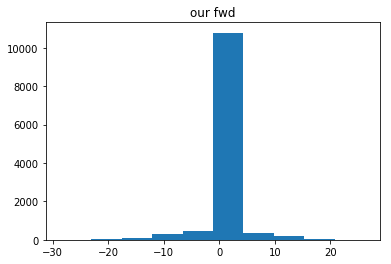

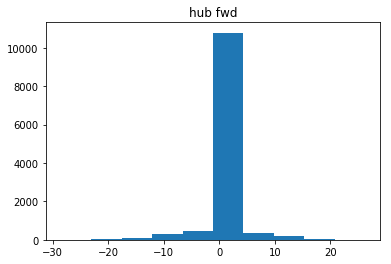

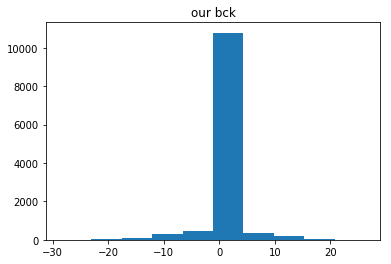

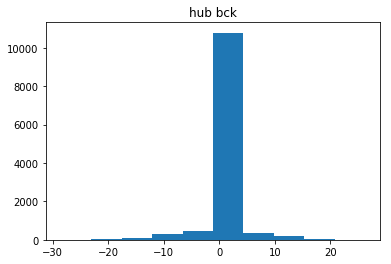

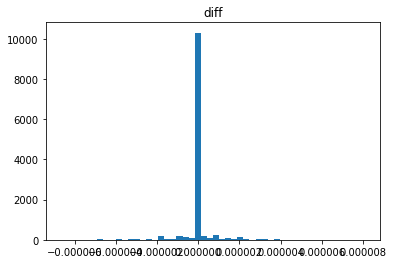

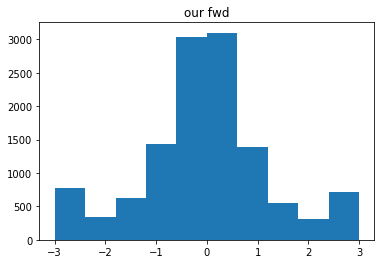

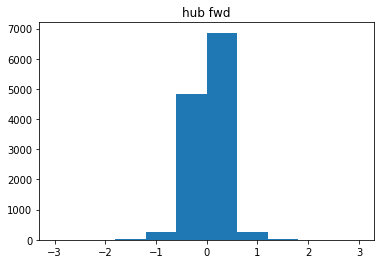

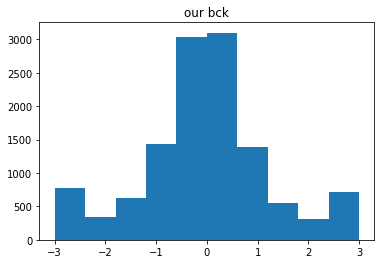

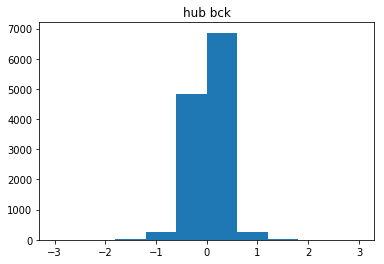

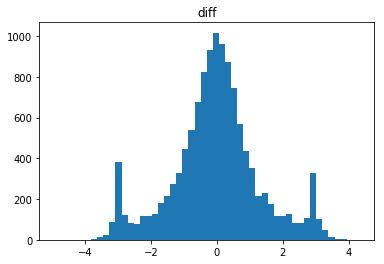

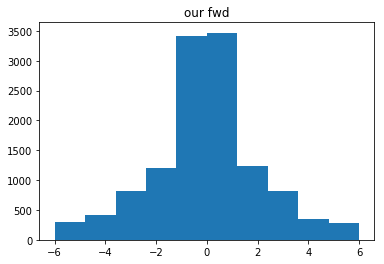

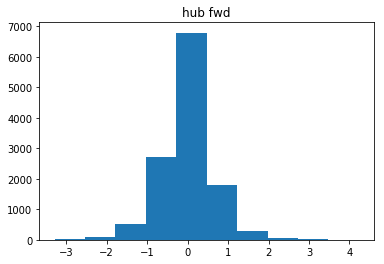

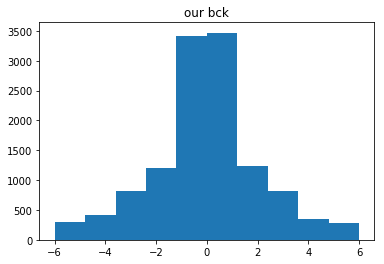

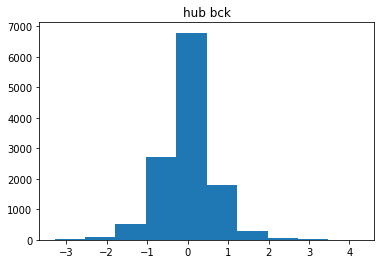

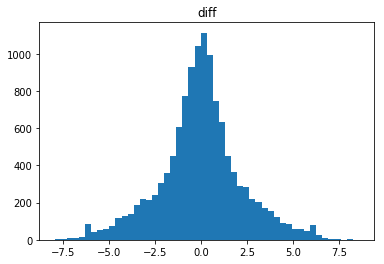

(3, 12, 1024) (3, 12, 1024)


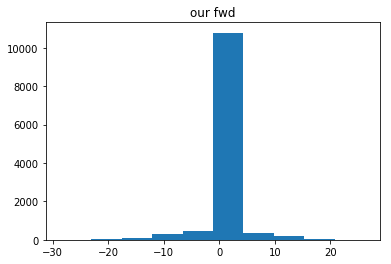

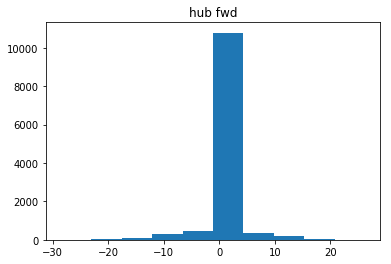

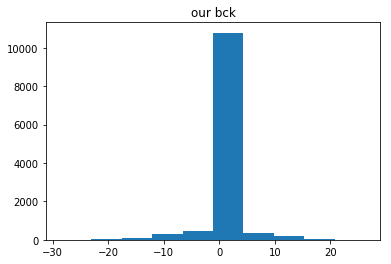

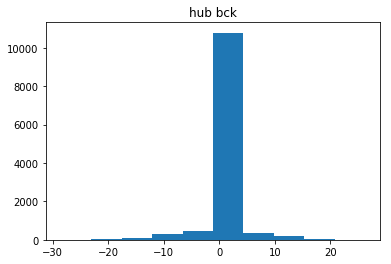

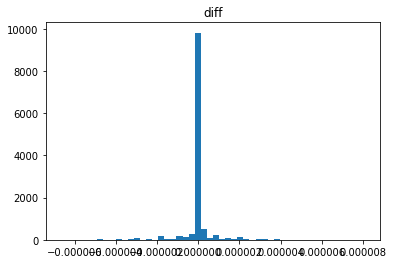

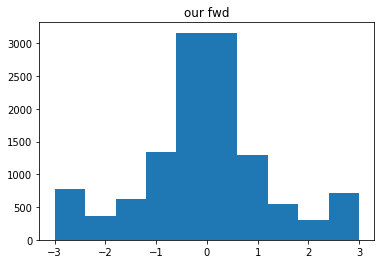

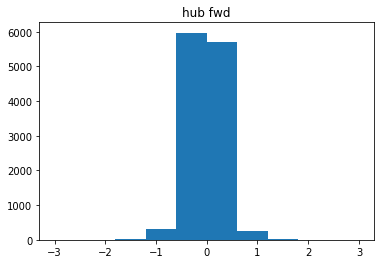

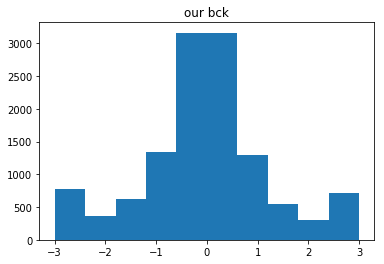

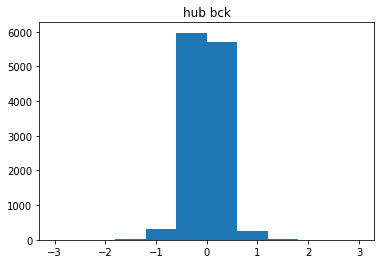

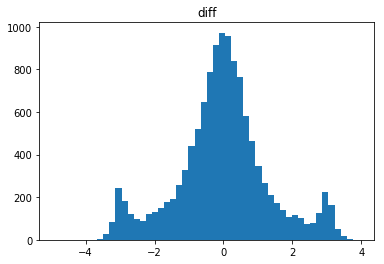

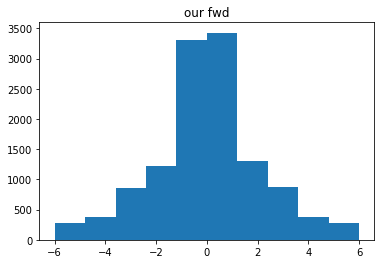

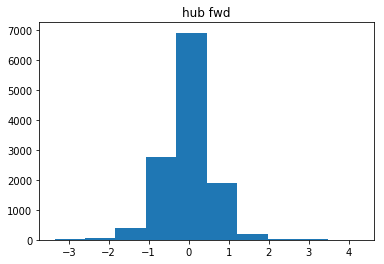

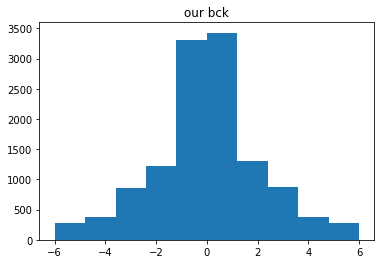

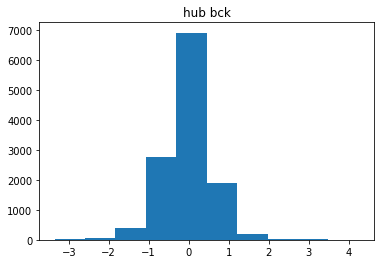

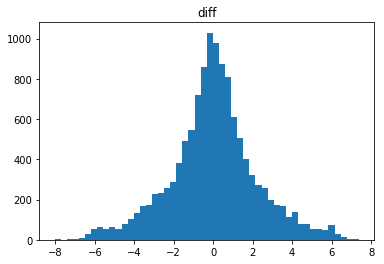

In [26]:
# our_input_embeddings_premises = our_embeddings_premises[:, 0, ..., :512]
# hub_input_embeddings_premises = hub_embeddings_premises[:, 0, ..., :512]

for our_embeddings, hub_embeddings in zip(our_embeddings_premises, hub_embeddings_premises):
    our_embeddings = our_embeddings[:, :hub_embeddings.shape[1], :]
    print(our_embeddings.shape, hub_embeddings.shape)
    
    for our_layer, hub_layer in zip(our_embeddings, hub_embeddings):
        
        for name, layer in zip(
            ['our fwd', 'hub fwd', 'our bck', 'hub bck'],
            [our_layer[:512], hub_layer[:512], our_layer[-512:], hub_layer[-512:]]
        ):
            fig, ax = plt.subplots()
            ax.hist(layer.flatten())
            ax.set_title(name)
            plt.show()
        
        diff = (our_layer - hub_layer).flatten()
        fig, ax = plt.subplots()
        ax.hist(diff, bins=50)
        ax.set_title('diff')
        plt.show()

In [28]:
# # Split concatenated input embeddings
# def split_embeddings(embeddings): # [batch, layer, word, dim]
#     after_split = []
#     for id_sen in range(embeddings.shape[0]):
#         input_embeddings = embeddings[id_sen][0] # [batch][layer]
#         assert np.allclose(input_embeddings[:, :512], input_embeddings[:, -512:])
#         input_embeddings = input_embeddings[:, :512]
#         after_split.append(input_embeddings)
#     return np.array(after_split)

In [29]:
# our_embeddings_premises = split_embeddings(elmo_our_output[0])
# our_embeddings_hypothesis = split_embeddings(elmo_our_output[1])
# print(our_embeddings_premises.shape)
# print(our_embeddings_hypothesis.shape)

(2, 90, 512)
(2, 90, 512)


In [98]:
# def get_mean_var(word_emb, title):
#     for id_sen in range(word_emb.shape[0]):
#         mean = np.mean(word_emb[id_sen], axis=-1)
#         var = np.var(word_emb[id_sen], axis=-1)
#         fig, ax = plt.subplots()
#         ax.set_title("%s mean" % title)
#         ax.bar(x=range(mean.shape[0]), height=mean)
        
#         fig, ax = plt.subplots()
#         ax.set_title("%s var" % title)
#         ax.bar(x=range(var.shape[0]), height=var)
        
# #         print(mean)
# #         print(var)
#         print("non-zeros: ", np.trim_zeros(np.sum(np.abs(word_emb[id_sen]), axis=-1)).shape[0])
        
#         plt.show()

In [ ]:
# # Czy nasze embeddingi dla paddingu są zero?
# get_mean_var(our_embeddings_premises, "premises")
# get_mean_var(our_embeddings_hypothesis, "hypo")

## For padding we have zero embeddings

In [23]:
# our_embeddings_premises = our_embeddings_premises[:, :hub_embeddings_premises.shape[1] ] # for <S>, </S> tokens
# our_embeddings_hypothesis = our_embeddings_hypothesis[:, :hub_embeddings_hypothesis.shape[1] ] # for <S>, </S> tokens
# print(our_embeddings_premises.shape)
# print(our_embeddings_hypothesis.shape)

AttributeError: 'list' object has no attribute 'shape'

In [25]:
# for our_embedding, hub_embedding in zip(our_embeddings_premises, hub_embeddings_premises):
#     print(our_embedding.shape, hub_embedding.shape)

(90, 512) (3, 10, 1024)
(90, 512) (3, 12, 1024)


In [126]:
# # <S>, </S> tokens match?
# def s_tokens_match(premises, length_premises, hypothesis, length_hypothesis):
#     print(np.allclose(premises[0][0], premises[1][0]))
#     print(np.allclose(premises[0][length_premises[0]], premises[1][length_premises[1]]))
#     print(np.allclose(hypothesis[0][0], hypothesis[1][0]))
#     print(np.allclose(hypothesis[0][length_hypothesis[0]], hypothesis[1][length_hypothesis[1]]))
#     print(np.allclose(premises[0][0], hypothesis[1][0]))
    
# s_tokens_match(our_embeddings_premises, 
#                length_premises,
#                our_embeddings_hypothesis,
#                length_hypothesis)

True
True
True
True
True


In [137]:
# # Czy embeddingi zgadzają się po usunięciu <S> i </S>?

# # in: [batch, word, dim]
# def compare_norms_and_dots(our, hub):
#     max_batch_size = 1
#     for id_sen in range(min(max_batch_size, our.shape[0])):
#         our_norms = np.linalg.norm(our[id_sen], axis=1, keepdims=True) + np.finfo(np.float32).eps
#         hub_norms = np.linalg.norm(hub[id_sen], axis=1, keepdims=True) + np.finfo(np.float32).eps
#         dots = np.sum(np.multiply(our[id_sen] / our_norms, hub[id_sen] / hub_norms), axis=1)
#         print("Our norms:", np.squeeze(our_norms))
#         print("Hub norms:", np.squeeze(hub_norms))
#         print("Diff:", np.squeeze(np.abs(our_norms - hub_norms)))
#         print("Dots:", np.squeeze(dots))

# compare_norms_and_dots(our_embeddings_premises[:, 1:-1], hub_embeddings_premises)

Our norms: [5.1239815e+00 5.7195163e+00 6.3369355e+00 3.5408201e+00 6.7391214e+00
 2.8376770e+00 6.7975278e+00 9.5500736e+00 1.4829599e+02 1.1920929e-07]
Hub norms: [ 7.808708  10.546759  10.28565    5.9961815 11.945176   4.6132913
 12.409397  12.182608   3.4311013  3.4311013]
Diff: [  2.6847267   4.8272424   3.9487147   2.4553614   5.2060547   1.7756143
   5.6118693   2.632534  144.86488     3.4311013]
Dots: [ 0.02830971  0.09484339  0.06101067  0.01735094  0.05132505  0.07046866
 -0.06401785  0.02944216  0.08591823  0.        ]


In [139]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# # word_emb_all = np.concatenate([word_emb_our, word_emb_their], axis=0)

# word_emb_all = np.concatenate([word_emb_their], axis=0)
# word_emb_all = np.reshape(word_emb_all, [-1, 512])

# word_emb_all_pca = pca.fit_transform(word_emb_all)

In [140]:
# word_emb_all_pca = np.reshape(word_emb_all_pca, [-1, 21, 2])
# word_emb_all_pca.shape

In [141]:
# word_emb_all

In [138]:
# def plot_prem_hypo(word_emb_all_pca):
#     labels = ['p1', 'h1', 'p2', 'h2']
#     colors = ['red', 'orange', 'black', 'gray']

#     # print(word_emb_all_pca.shape)

#     fig, ax = plt.subplots()
#     for i in range(word_emb_all_pca.shape[0]):
#         label = labels[i]
#         x, y = zip(*word_emb_all_pca[i])
#         ax.scatter(x=x, y=y, c=colors[i], label=label)

#     ax.legend()
#     plt.show()
    
# plot_prem_hypo(word_emb_all_pca)